# Statistical and Predictive Analysis of Hepatitis C dataset

Author: Khadija Musayeva

The current report represents statistical and predictive modeling done on the Hepatitis C dataset publicly available at UCI website https://archive.ics.uci.edu/dataset/571/hcv+data.

The dataset consists of 615 patients characterized by age, sex, and laboratory tests values of 10 biochemical blood test markers. The target consists of 4 classes: Blood Donor, Hepatitis-C, Fibrosis, Cirrhosis.

Statistical analysis consists of the analysis of distribution of variables, prevalence of disease cases across variables, and adjusted odds ratio analysis.

Predictive modeling firtst discriminates all disease cases aggregated into one from blood donors and secondly, all four classes from each other.

F1, AUC, sensitivity, specificity, Matthews correlations coefficients are used as evaluation measures in the binary classification setting, and macro and micro F1 measures and Matthews correlation coefficient are used as evaluation measures in the multi-class classification setting. In both setting, the models are trained based on the Matthews correlation coefficient which evaluates the confusion matrix in ints entirety.

We use Optuna framework for hyperparameter training. 

Half of the data is used as training set and the other half as a test set.

Predictive methods used are logistic regression, support vector machine, random forest, xgboost and neural networks.

In the binary setting, logistic regression has a higher sensitivity, and random forest and neural networks have higher specificities.

In the multi-class classification setting,  logistic regression makes fewer errors in predicting hepatitis C and fibrosis cases, and equally well as neural network in predicting cirrhosis cases. However, it misclassifies many blood donors as disease cases.

It should be noted that quantitave models like logistic regression is supported by Arden Syntax which programs medical logic for clinical decision support, but not black box models of higher capacity such as random forests or neural networks.

# Visualization

Here we load the cleaned version of the data.

In [1]:
from DataProcess import *
from DataVisualize import *
from BinaryClassificationTraining import *
from BinaryClassificationEvaluation import *
from MultiClassificationTraining import *
from MultiClassificationEvaluation import *

In [2]:
dp = DataProcess("data/HepatitisCdata.csv")
data_vis = DataVisualize(dp)
df = dp.getFinalData()

File read successfully: data/HepatitisCdata.csv


## Distribution of Target Variable

This is a dataset with high class imbalance, where only 12% of observations are disease cases.

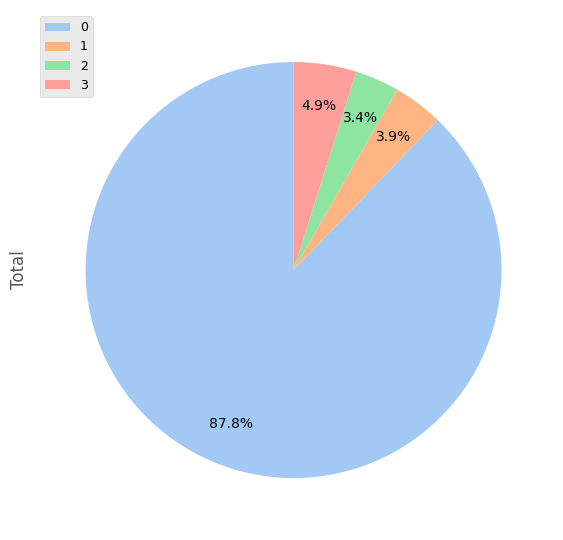

In [3]:
data_vis.Target()

## Age and Disease

The minimum and maximum ages in the dataset are 19 and 77, respectively. The mean age is 47. There are few individuals between 19 and 30 years of age. As the plot below demonstrates, these younger individuals are Hepatitis C patients.

In [13]:
df["Age"].describe()

count    615.000000
mean      47.408130
std       10.055105
min       19.000000
25%       39.000000
50%       47.000000
75%       54.000000
max       77.000000
Name: Age, dtype: float64

If we consider only binary target variable corresponding to healthy vs disease cases, there is much crossover between the class conditional age distributions. However, separated by disease severity, hepatitis C patients, in general, are younger than fibrosis and cirrhosis patiens with the minimum age of 19 and the median age of 37. The age distribution of cirrhosis patients is negatively skewed with median of 56 and with all its percentiles higher than those of fibrosis patients. The percentiles of hepatitis are lower than that of healthy individuals and the percentiles of the age distributions of fibrosis and cirrhosis patients are higher than that of healthy individuals. Thus, the age distribution for the  aggregated disease status displays high variance, with much crossover with that of healthy individuals.

In [20]:
df[["Age", "Diagnosis"]].groupby("Diagnosis").describe()

Age                                                    
             count       mean        std   min   25%   50%   75%   max
Diagnosis                                                             
Blood Donor  540.0  47.266667   9.704311  32.0  39.0  47.0  54.0  77.0
Cirrhosis     30.0  53.466667   8.908475  38.0  46.0  56.0  59.0  74.0
Fibrosis      21.0  52.333333  11.438240  29.0  48.0  51.0  57.0  75.0
Hepatitis     24.0  38.708333  11.350078  19.0  31.5  37.0  47.0  61.0

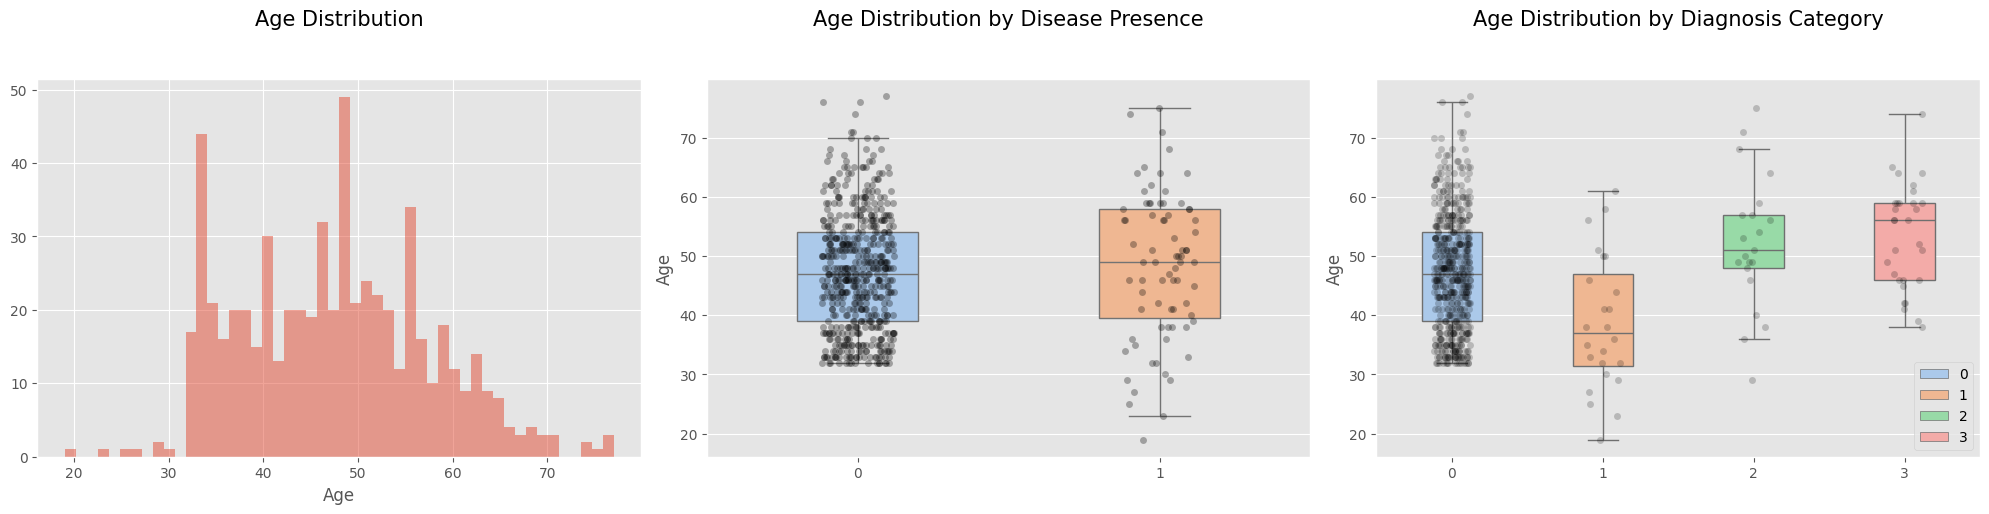

In [21]:
data_vis.AgeDisease()

## Gender and Disease

In the dataset, 61% percent of individuals are males.

In [22]:
gender_counts = df['Sex'].value_counts().sort_index()

display(round(100 * gender_counts / gender_counts.sum(), 2))

Sex
f    38.7
m    61.3
Name: count, dtype: float64

There are more hepatitis C and cirrhosis cases among males.

In [23]:
 gender_diagnosis = (df.groupby(['Sex', 'Diagnosis'])
    .size()
    .groupby(level=0)
    .apply(lambda x: round(100 * x / x.sum(), 2))
    .reset_index(level=0, drop=True)
  )

 display(gender_diagnosis.reset_index(name="Percentage")\
         .sort_values(by=['Diagnosis', 'Sex'], key=lambda x: x.map(dp.diagnosis_dict)))

,Sex,Diagnosis,Percentage
0,f,Blood Donor,90.76
4,m,Blood Donor,85.94
3,f,Hepatitis,1.68
7,m,Hepatitis,5.31
2,f,Fibrosis,3.36
6,m,Fibrosis,3.45
1,f,Cirrhosis,4.20
5,m,Cirrhosis,5.31


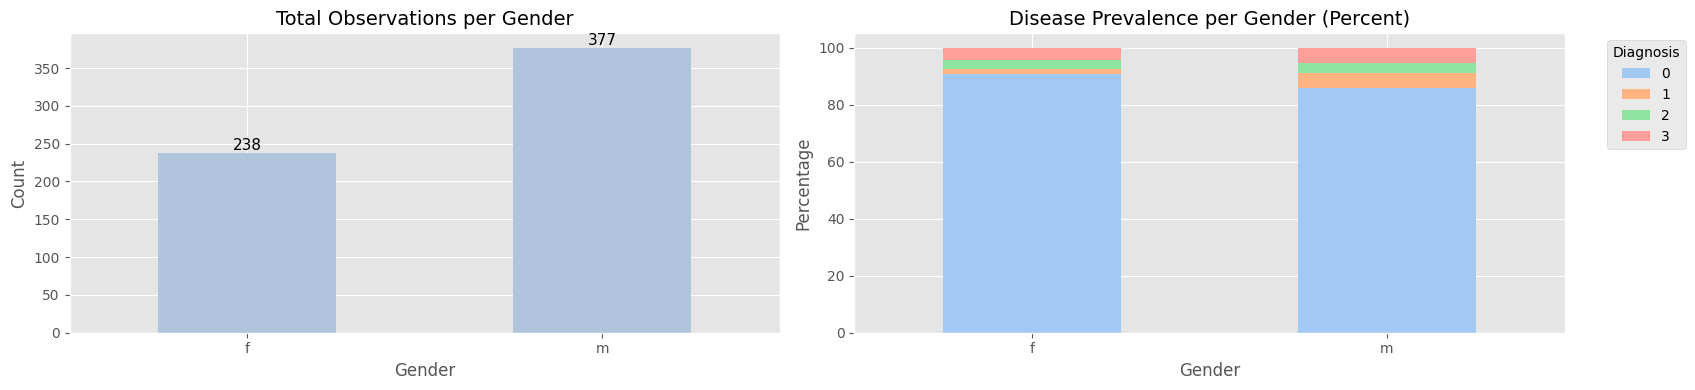

In [24]:
data_vis.GenderDisease()

## Biomarkers and Disease

Before visualization, we need to verify which variables have missing values.
ALP predictor has 18 missing values, all in disease individuals. Given small number of observations in disease classes, this variable is not a reliable predictor. CHOL has more missing values in healthy individuals. One hepatitis patient is missing ALT value, and one cirrhosis patient is missing PROT value.

Because there is a high biological variability between individuals, from precision medecine point of view, would it be a right strategy to impute these values, for instance, using k-nearest neighbour approach? In predictive modeling, we drop ALP predictor altogether.


In [ ]:
df.loc[df.isna().any(axis=1)]

,Diagnosis,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Diagnosis_Label,Diagnosis_Binary
121,0,43,m,48.6,45.0,10.5,40.5,5.3,7.09,NaN,63.0,25.1,70.0,Blood Donor,0
319,0,32,f,47.4,52.5,19.1,17.1,4.6,10.19,NaN,63.0,23.0,72.2,Blood Donor,0
329,0,33,f,42.4,137.2,14.2,13.1,3.4,8.23,NaN,48.0,25.7,74.4,Blood Donor,0
413,0,46,f,42.9,55.1,15.2,29.8,3.6,8.37,NaN,61.0,29.0,71.9,Blood Donor,0
424,0,48,f,45.6,107.2,24.4,39.0,13.8,9.77,NaN,88.0,38.0,75.1,Blood Donor,0
433,0,48,f,46.8,93.3,10.0,23.2,4.3,12.41,NaN,52.0,23.9,72.4,Blood Donor,0
498,0,57,f,48.4,94.4,2.5,39.6,2.3,8.84,NaN,82.0,6.4,76.8,Blood Donor,0
540,1,38,m,45.0,56.3,NaN,33.1,7.0,9.58,6.0,77.9,18.9,63.0,Hepatitis,1
541,1,19,m,41.0,NaN,87.0,67.0,12.0,7.55,3.9,62.0,65.0,75.0,Hepatitis,1
545,1,29,m,49.0,NaN,53.0,39.0,15.0,8.79,3.6,79.0,37.0,90.0,Hepatitis,1


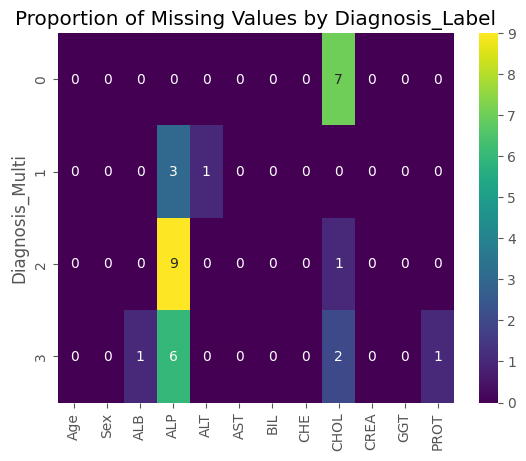

In [30]:
data_vis.missingness()

#### ALB

Albumin distribution is bell shaped. The distributions corresponding to hepatitis and fibrosis mostly overlap with each other as well as with that of healthy individuals. All percentiles of ALB levels of cirrhosis patients are lower than the other groups. There are healthy individuals with low ALB levels overlapping with cirrhosis ALB levels.


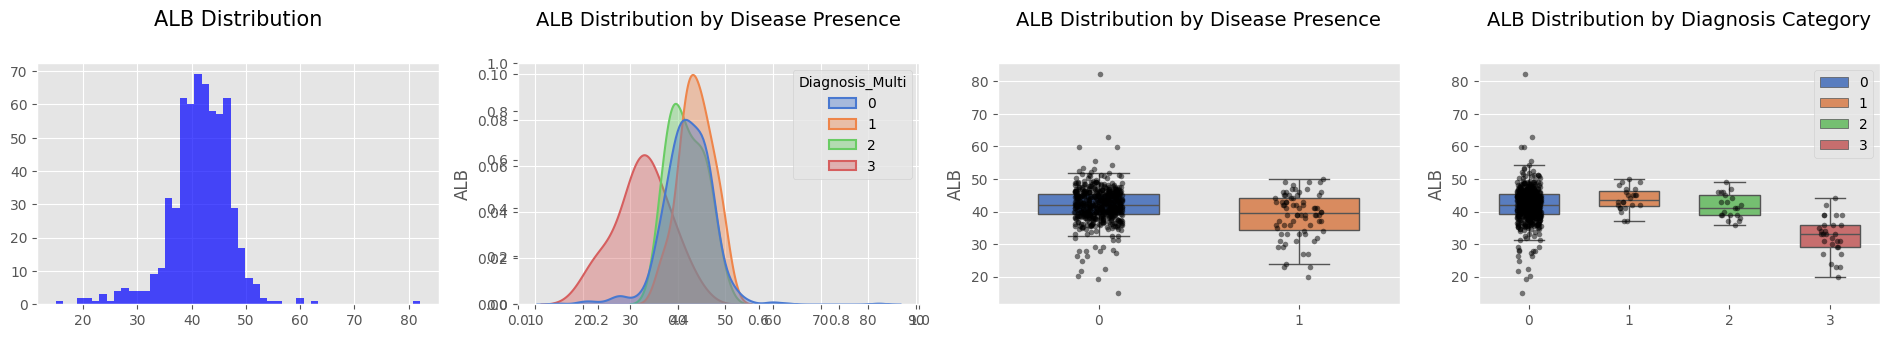

In [5]:
data_vis.Biomarkers("ALB")

In [3]:
data_vis.BiomarkerSummary("ALB")

ALB                                                      
                 count       mean       std   min    25%   50%     75%   max
Diagnosis_Multi                                                             
0                540.0  42.007037  5.508191  14.9  39.10  42.1  45.325  82.2
1                 24.0  43.833333  3.509821  37.0  41.75  43.5  46.250  50.0
2                 21.0  41.761905  3.740384  36.0  39.00  41.0  45.000  49.0
3                 29.0  32.482759  5.816360  20.0  29.00  33.0  36.000  44.0

#### ALP

The ALP distribution is bell-shaped, with several outliers. Hepatitis C and fibrosis patients have lower levels of ALP compared to normal individuals, that of cirrhosis patients is very much spread out, with a high variance. But one should take into account that, this predictor has 18 missing values: 9 in fibrosis, 6 in cirrhosis and 3 in hepatitis group.

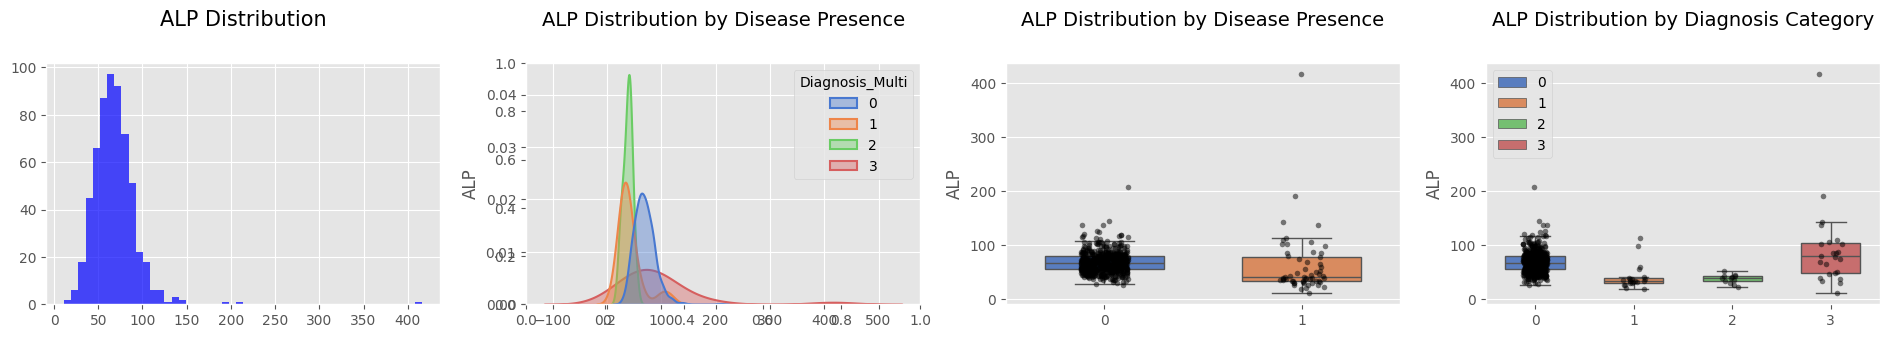

In [4]:
data_vis.Biomarkers("ALP")

In [5]:
data_vis.BiomarkerSummary("ALP")

ALP                                                      \
                 count       mean        std   min     25%    50%      75%   
Diagnosis_Multi                                                              
0                540.0  68.869815  19.452747  27.0  55.300  66.95   80.125   
1                 21.0  42.114286  23.517935  19.1  31.200  34.60   39.600   
2                 12.0  37.841667   8.308753  22.9  33.300  39.55   43.100   
3                 24.0  93.220833  80.048284  11.3  48.875  80.05  103.575   

                        
                   max  
Diagnosis_Multi         
0                208.2  
1                114.0  
2                 52.1  
3                416.6

#### BIL

The BIL distribution of cirrhosis patients stands out, it is spread-out with values ranging from below 50 up to 250, whereas the remaining groups have BIL distributions very much concetrated around their means. That of fibrosis patients, and that of hepatitis C patients except for one individual, completely overlap with the BIL distribution of healthy individuals.

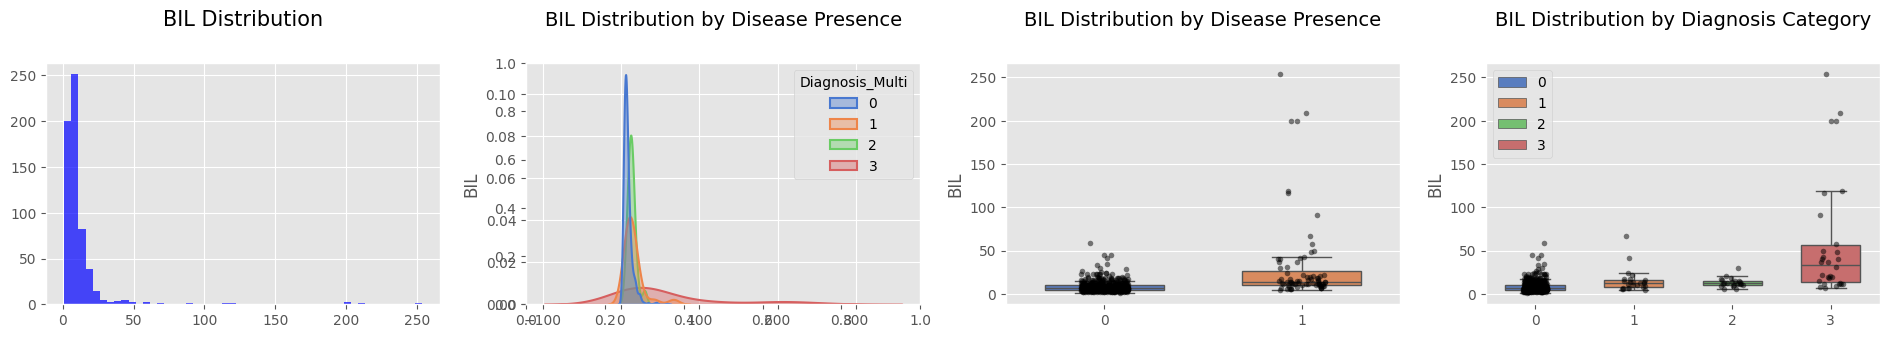

In [6]:
data_vis.Biomarkers("BIL")

In [7]:
data_vis.BiomarkerSummary("BIL")

BIL                                                        
                 count       mean        std  min     25%   50%     75%    max
Diagnosis_Multi                                                               
0                540.0   8.477778   6.072184  0.8   4.975   6.9  10.025   59.1
1                 24.0  15.625000  13.467554  5.0   7.750  13.0  16.250   67.0
2                 21.0  13.428571   5.325143  6.0  10.000  13.0  15.000   30.0
3                 30.0  59.133333  69.367951  7.0  13.500  34.0  56.000  254.0

#### CHE

Choline Esterase is approximately normally distributed, but when separated based on the disease status, the one of cirrhosis individuals stands out: all percentiles are lower than the remaining groups.

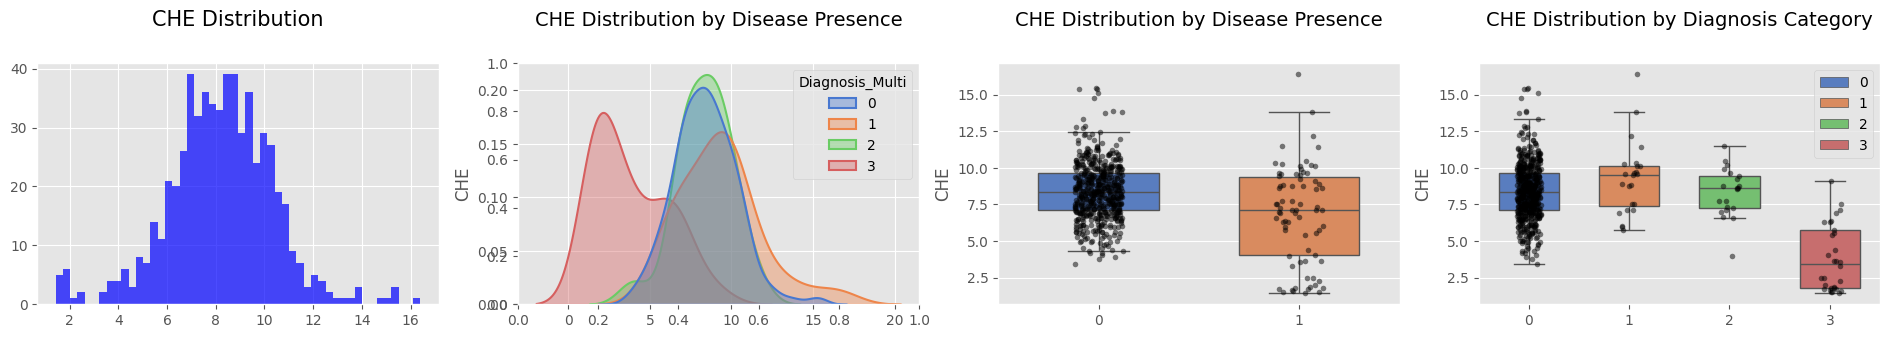

In [9]:
data_vis.Biomarkers("CHE")

In [8]:
data_vis.BiomarkerSummary("CHE")

CHE                                                    \
                 count      mean       std   min     25%    50%      75%   
Diagnosis_Multi                                                            
0                540.0  8.386185  1.934784  3.44  7.0825  8.325   9.6225   
1                 24.0  9.283750  2.506341  5.75  7.4050  9.510  10.1475   
2                 21.0  8.334762  1.668399  3.99  7.2800  8.590   9.4500   
3                 30.0  3.818333  2.243559  1.42  1.8000  3.425   5.7200   

                        
                   max  
Diagnosis_Multi         
0                15.43  
1                16.41  
2                11.49  
3                 9.07

#### GGT

All percentiles of GGT of all disease groups are higher than those of healthy individuals. But those of cirrhosis individuals are higher and more spread.

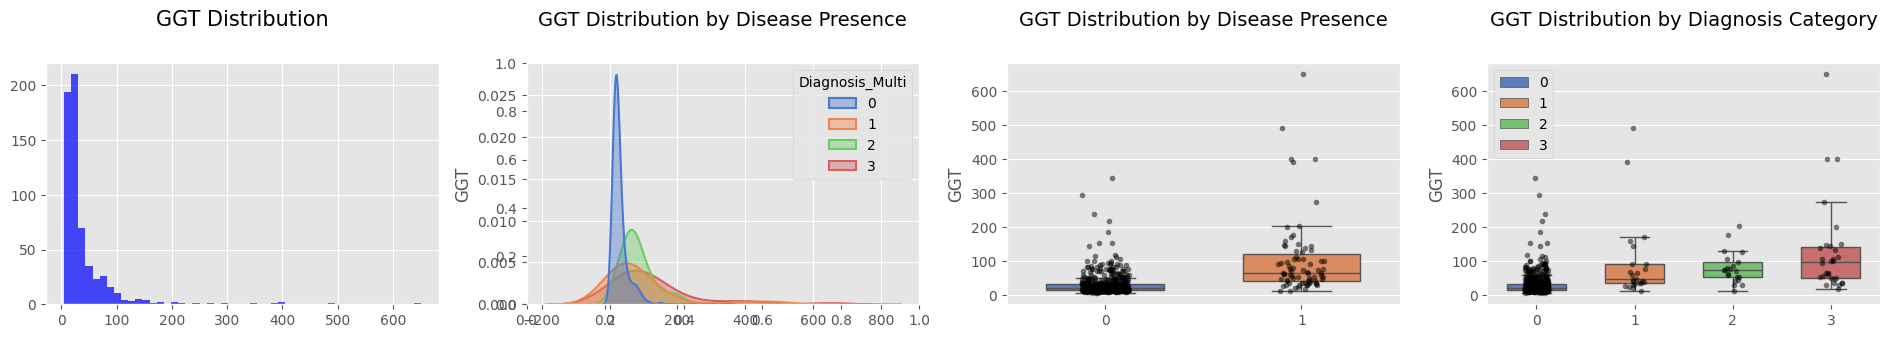

In [10]:
data_vis.Biomarkers("GGT")

#### AST

Regrading AST, although there is some overlap over between those of disease cases and that of healthy individuals, judging based on the plots below, this variable has a high discrimanatory power. Those of disease cases are highly spread out, with high variance. As the disease gets more severe, the percentiles increase.

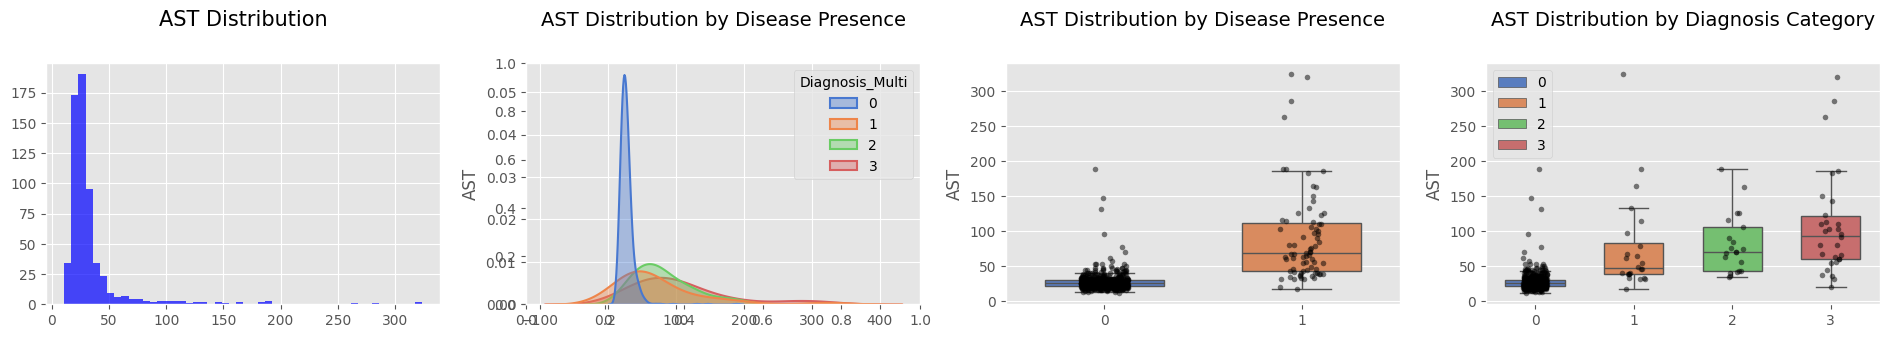

In [12]:
data_vis.Biomarkers("AST")

#### ALT

ALT of fibrosis group stands out: it are very spread out. The median of hepatitis and cirrhosis are lower than that of healthy individuals. These two distributions very much overlap with that of healthy individuals.

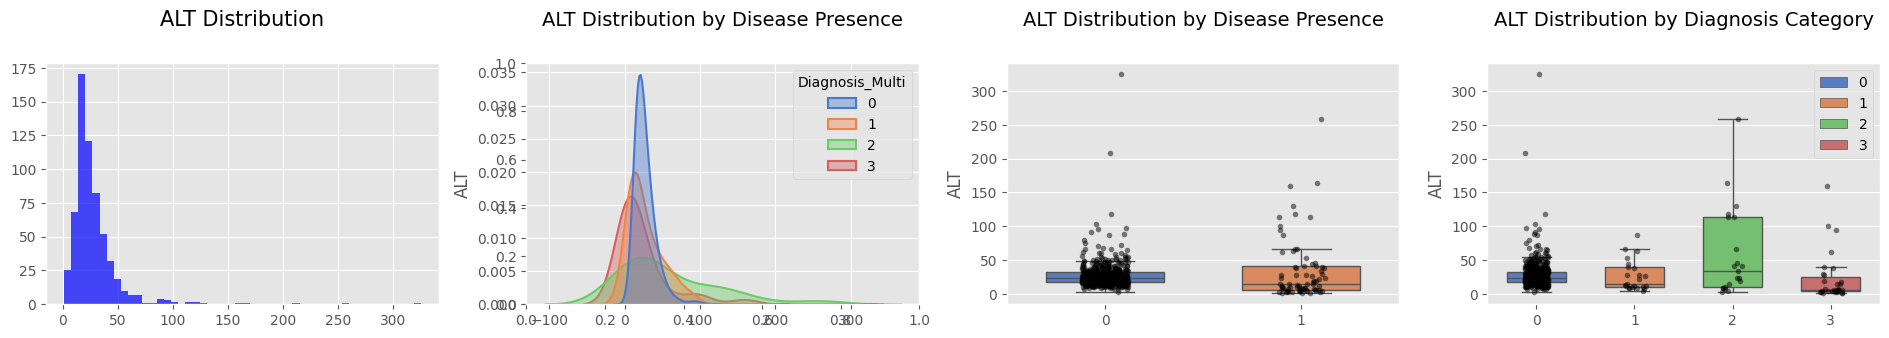

In [13]:
data_vis.Biomarkers("ALT")

#### CHOL

All percentiles of CHOL of all disease groups are below the corresponding ones of no-disease group and it gets lower as the severity of the condition increases.

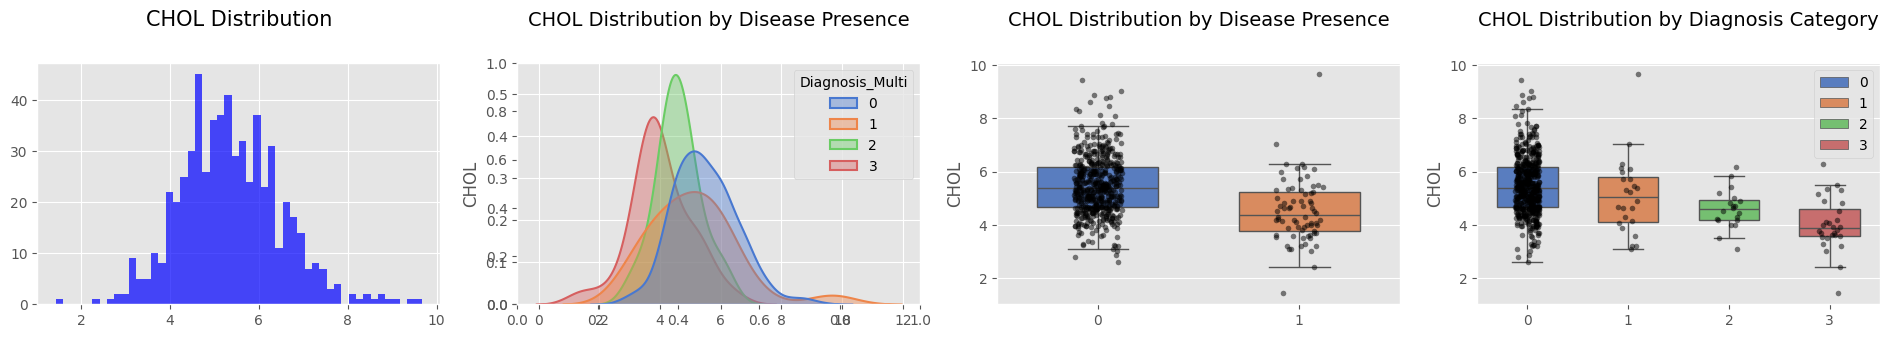

In [14]:
data_vis.Biomarkers("CHOL")

#### PROT

PROT values of hepatitis and fibrosis groups tend to be higher, those of cirrhosis are more spread out, with almost all percentiles below those of the former two groups. If we look at only the binary disease outcome, in general, the distribution of PROT for disease indivuals are pulled above than those without the disease, however there are individuals without the disease with PROT values below 50.

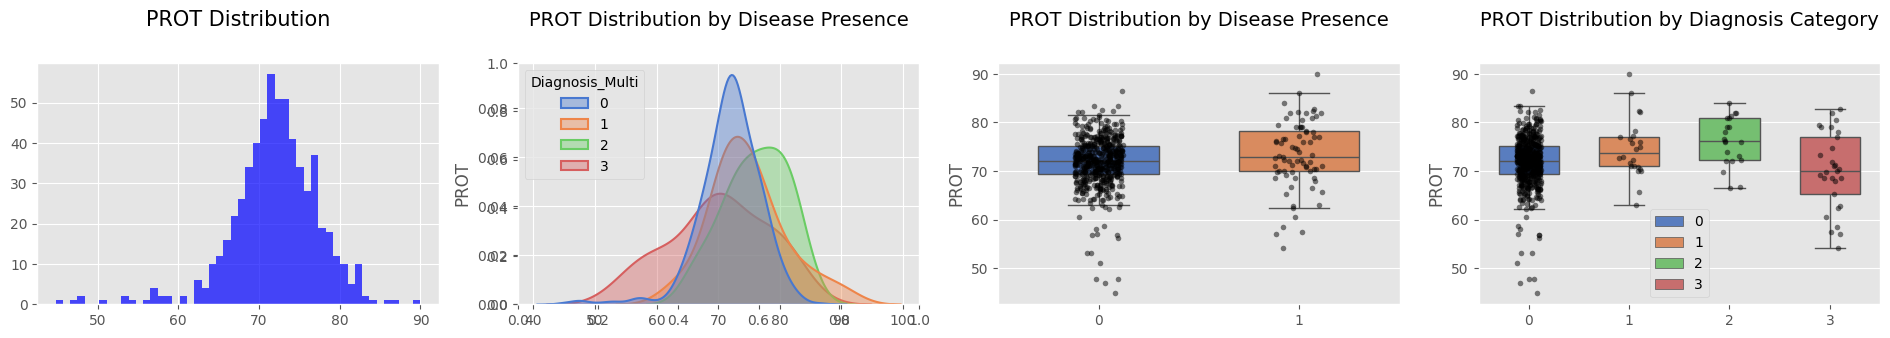

In [15]:
data_vis.Biomarkers("PROT")

#### CREA

CREA is not a discriminative for disease status,  a lot of shared variation between groups, except for three cirrhosis individuals with very high CREA values.

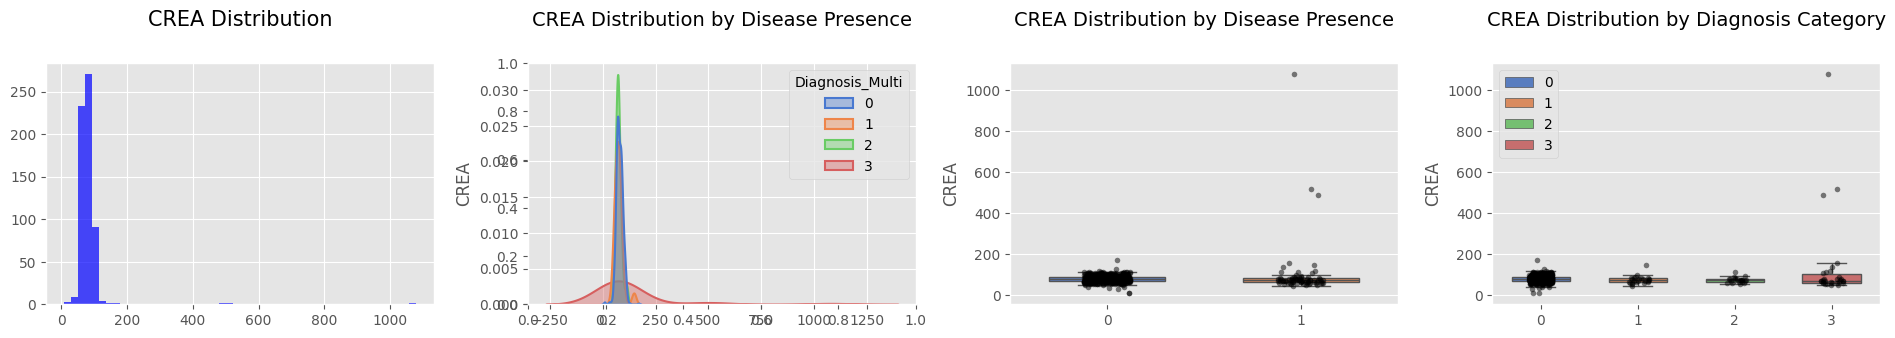

In [16]:
data_vis.Biomarkers("CREA")

#### Pairwise Plots

Pairwise relationships do not show any particular tendency and form.

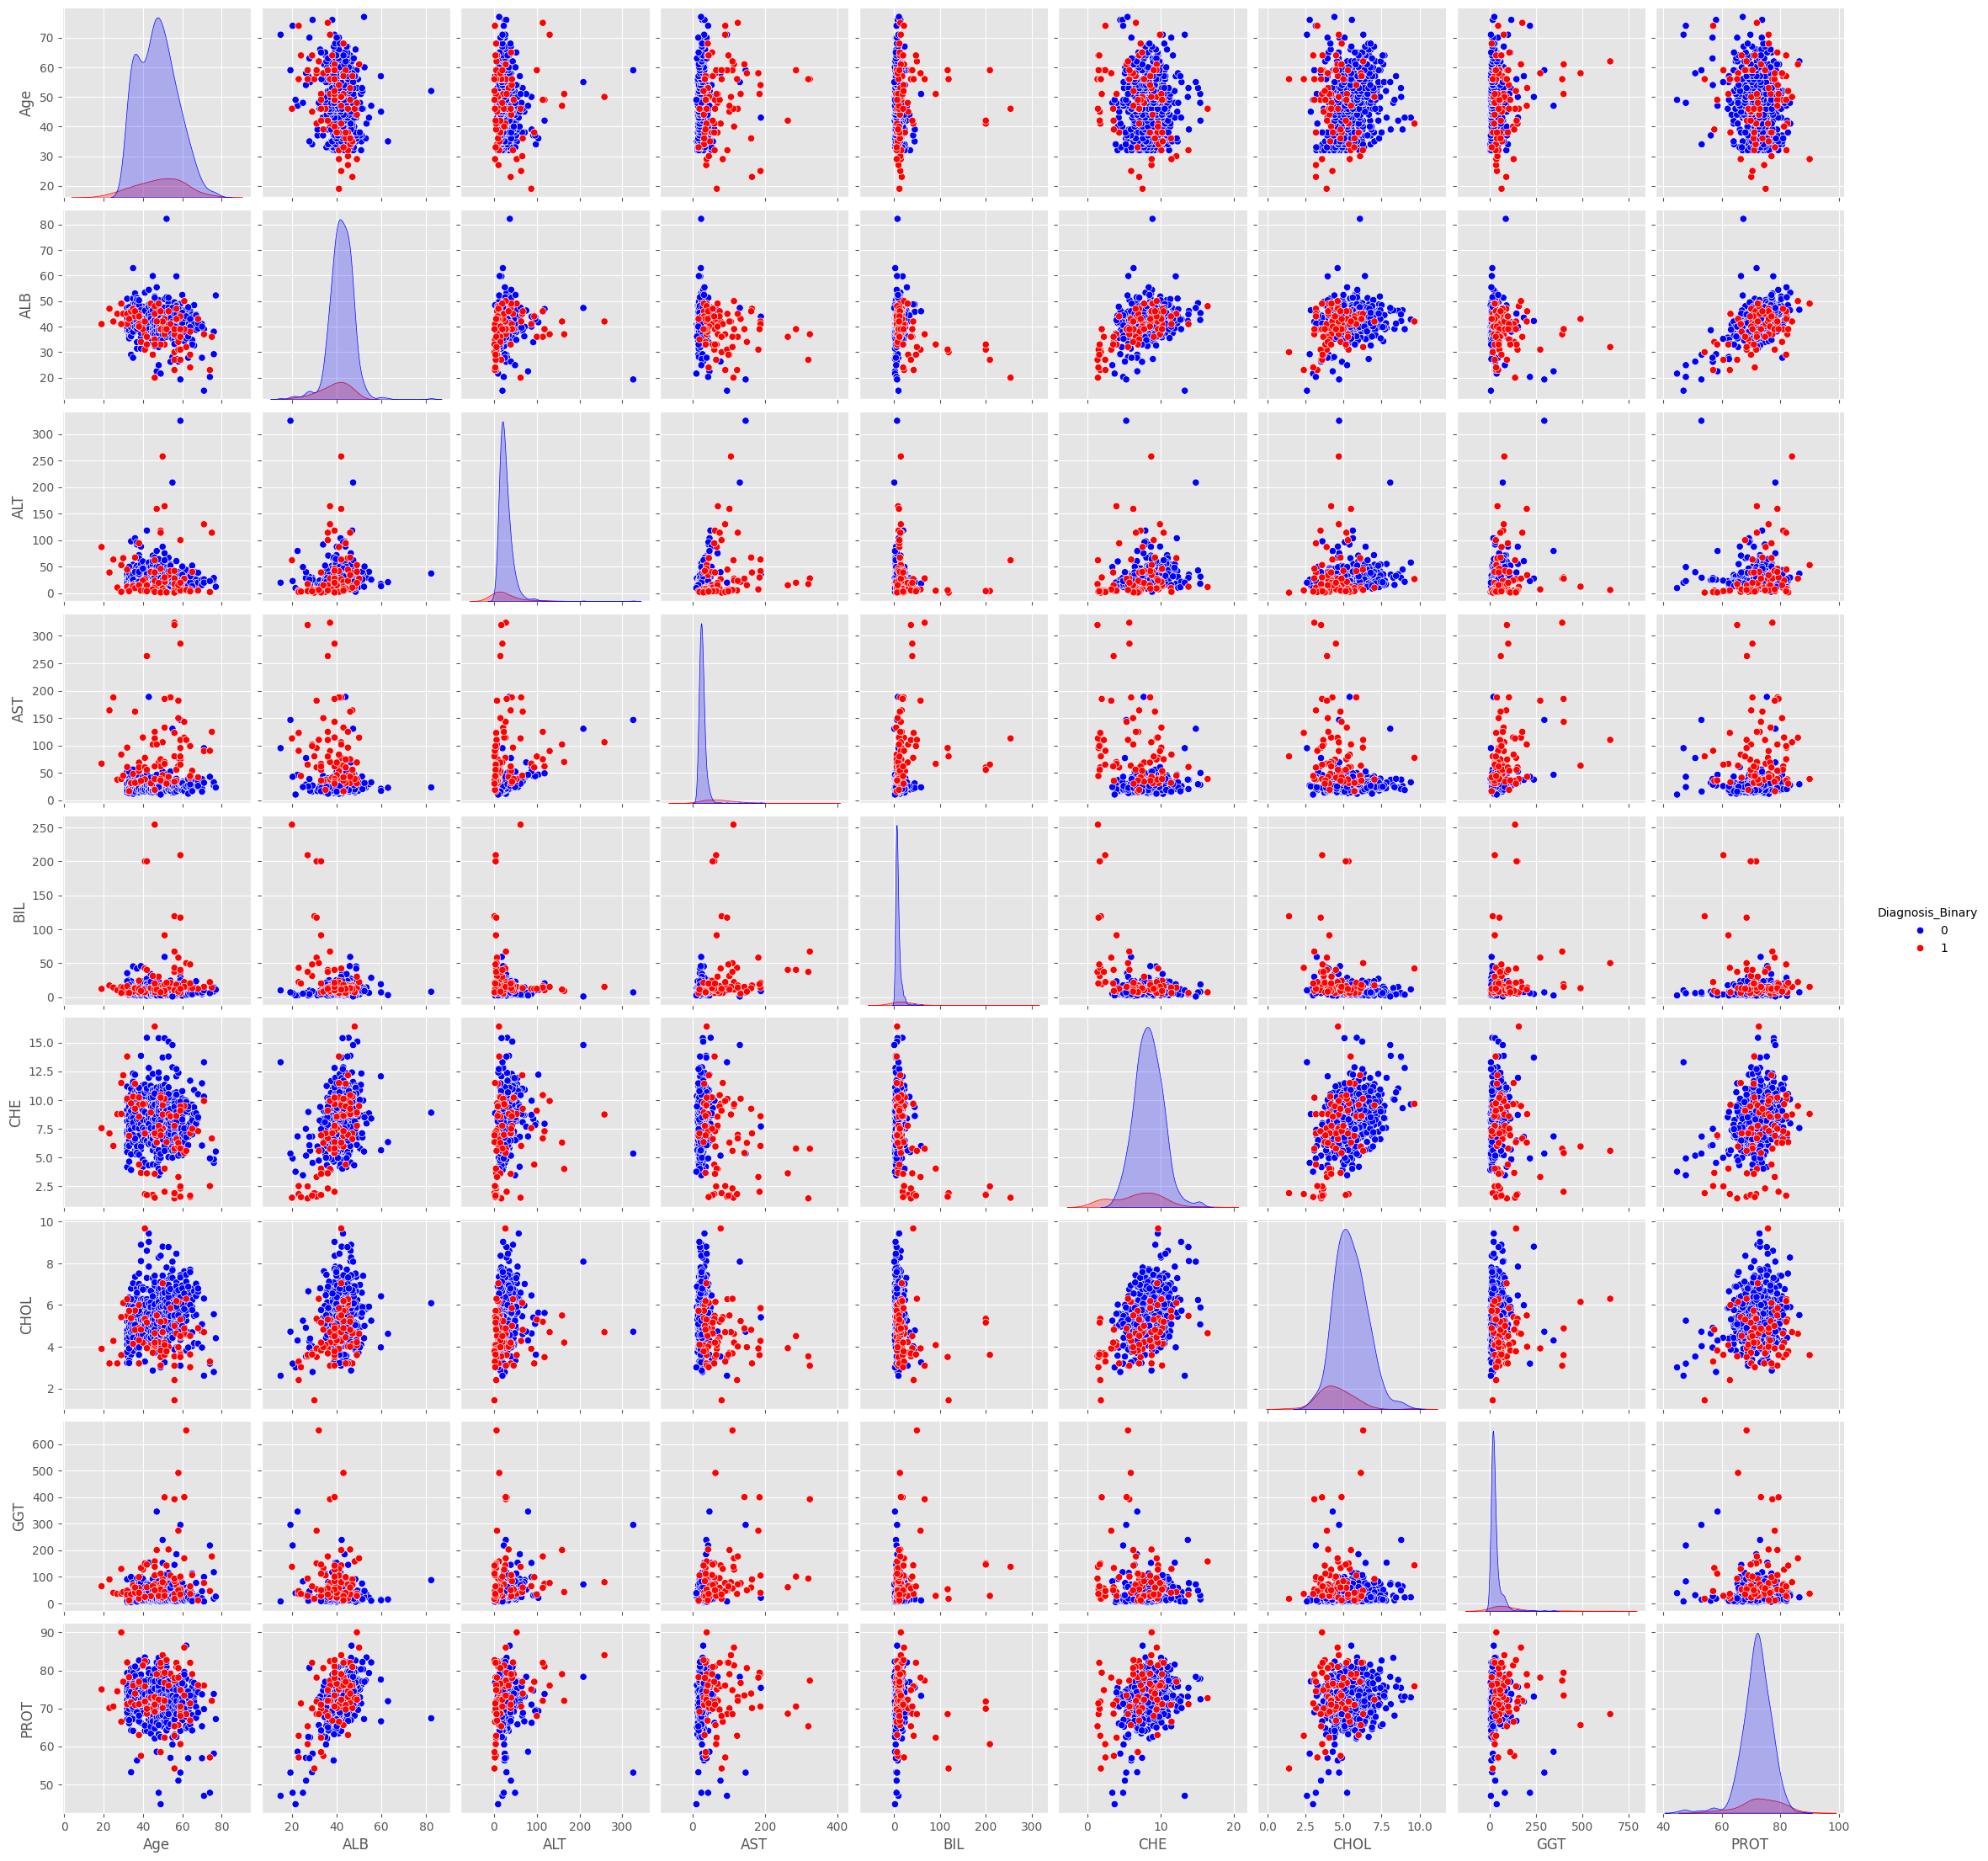

In [18]:

pairs = df.drop(columns=["Diagnosis", "Diagnosis_Multi", "Sex", "CREA", "ALP"])
palette = {0: "blue", 1: "red"}
sns.pairplot(pairs, hue="Diagnosis_Binary", palette=palette)
plt.show()


## Adjusted Odds Ratio

We consider adjusted odds ratio (AOR) for binary outcome:  healthy individuals vs all disease cases aggregated into one disease status. The underlying assumption of logistic regression is that the relationship between the log odds of liver disease and a predictor of interest is linear adjusted for all remaining variables. If this relationship does not hold, then the obtained results could be be erroneous. Also, the disease groups have a small number of observations, so the obtained results should be interpreted with caution (small sample size makes it hard to detect a signal if there exists one, i.e., statistical tests do not have power to detect it.)

There are some missing values in several predictors for disease individuals. ALP has 18 missing values in disease groups, so we will remove this column entirely (although we could do k- nearest neighbour imputation it might raise a question from precision point of view due to a high biological variability among individuals). For the remaining missing values, we will only remove the rows. After adjusting for sex and age, the statistically significant predictors are ALB, ALT, AST, BIL, GGT, CREA and PROT. Age, and sex are not statistically significant predictors after adjusting for other variables.

In [5]:
import statsmodels.api as sm

A = df[["Age", "Sex", "ALB", "ALT", "AST", "BIL", "CHE", "GGT", "CREA", "PROT"]]

# Reset index to ensure alignment after dropna
A = A.dropna().reset_index(drop=True)

A = A.drop(columns="Sex").join(pd.get_dummies(df["Sex"], drop_first=True, dtype=int, prefix="Sex"))

A = sm.add_constant(A)

outcome = df["Diagnosis_Binary"]

# Align outcome index with A's index
outcome = outcome[A.index] # Subset outcome based on A's index

model = sm.Logit(outcome, A).fit(disp=0)

print(model.summary())

                           Logit Regression Results                           
Dep. Variable:       Diagnosis_Binary   No. Observations:                  612
Model:                          Logit   Df Residuals:                      601
Method:                           MLE   Df Model:                           10
Date:                Fri, 09 May 2025   Pseudo R-squ.:                  0.6375
Time:                        13:56:59   Log-Likelihood:                -80.358
converged:                       True   LL-Null:                       -221.67
Covariance Type:            nonrobust   LLR p-value:                 7.257e-55
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.4501      3.625     -5.089      0.000     -25.555     -11.345
Age           -0.0316      0.022     -1.465      0.143      -0.074       0.011
ALB           -0.1049      0.050     -2.119      0.0

##### Linearity Assumption

We would like to check the linearity assumption by categorizing the continuous predictors into 4 quartiles, i.e., 4 ordinal categories.

We focus on GGT. From the boxplot illustration above one can see the median of (class-conditional) GGT distribution increases with the increasing severity of the disease.

Below, we categorized GGT based into 4 ordinal categories based on 4 quartiles. It clearly shows the increasing number of patients with the increasing order of GGT category.

Since almost all patients are concentrated in the final two quartiles, GGT_3 and GGT_4 are statistically significant predictors. One can see a consistent increase in the log odds of liver disease across ordinal GGT categories.

In [ ]:
def verify_linearity(var, dat, outcome):

  dat = pd.concat([
    pd.get_dummies(pd.qcut(dat[var], 4, labels=[1, 2, 3, 4]), prefix=var, dtype=int, drop_first=True),
    dat
    ], axis=1).drop(columns=[var])

  dat = sm.add_constant(dat)

  return sm.Logit(outcome, dat).fit(disp=0)


In [ ]:
dat = df[["Diagnosis_Binary", "Age", "Sex", "ALB", "ALT", "AST", "BIL", "CHE", "CREA", "GGT", "PROT"]]\
.dropna()

outcome = dat["Diagnosis_Binary"]

dat.drop(columns="Diagnosis_Binary", inplace=True)

dat = pd.concat([dat, pd.get_dummies(dat["Sex"], drop_first=True, dtype=int, prefix="Sex")], axis=1).drop(columns="Sex")

In [ ]:
print(pd.crosstab(pd.qcut(df['GGT'], 4, labels=[1, 2, 3, 4]), df['Diagnosis_Binary']))

result = verify_linearity("GGT", dat, outcome)

print(result.summary())

Diagnosis_Binary    0   1
GGT                      
1                 153   2
2                 151   3
3                 138  15
4                  98  55
                           Logit Regression Results                           
Dep. Variable:       Diagnosis_Binary   No. Observations:                  612
Model:                          Logit   Df Residuals:                      599
Method:                           MLE   Df Model:                           12
Date:                Fri, 02 May 2025   Pseudo R-squ.:                  0.6792
Time:                        08:50:23   Log-Likelihood:                -71.113
converged:                       True   LL-Null:                       -221.67
Covariance Type:            nonrobust   LLR p-value:                 2.732e-57
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.5096      3.755     -4.131      0.000

Similarly, we see consistent increase in the log odds of liver disease with the increasing ordinal category of BIL.

In [ ]:
print(pd.crosstab(pd.qcut(df['BIL'], 4, labels=[1, 2, 3, 4]), df['Diagnosis_Binary']))

result = verify_linearity("BIL", dat, outcome)

print(result.summary())

Diagnosis_Binary    0   1
BIL                      
1                 159   1
2                 147   8
3                 133  14
4                 101  52
                           Logit Regression Results                           
Dep. Variable:       Diagnosis_Binary   No. Observations:                  613
Model:                          Logit   Df Residuals:                      601
Method:                           MLE   Df Model:                           11
Date:                Fri, 02 May 2025   Pseudo R-squ.:                  0.6785
Time:                        08:49:03   Log-Likelihood:                -71.950
converged:                       True   LL-Null:                       -223.81
Covariance Type:            nonrobust   LLR p-value:                 1.446e-58
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -23.4713      6.375     -3.682      0.000

No linear trend in log odds with respect to PROT, since the log odds decreases from the 2nd category to the third one, and then increases with respect to fourth.

In [ ]:
print(pd.crosstab(pd.qcut(df['PROT'], 4, labels=[1, 2, 3, 4]), df['Diagnosis_Binary']))

result = verify_linearity("PROT", dat, outcome)

print(result.summary())

Diagnosis_Binary    0   1
PROT                     
1                 139  17
2                 139  16
3                 143  10
4                 119  31
                           Logit Regression Results                           
Dep. Variable:       Diagnosis_Binary   No. Observations:                  612
Model:                          Logit   Df Residuals:                      599
Method:                           MLE   Df Model:                           12
Date:                Fri, 02 May 2025   Pseudo R-squ.:                  0.6196
Time:                        09:25:42   Log-Likelihood:                -84.314
converged:                       True   LL-Null:                       -221.67
Covariance Type:            nonrobust   LLR p-value:                 9.370e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5406      2.337     -2.371      0.018

With increasing ALB category, the log odds decreases consistently, although this is not very much linearly, since there is a sharp drop from the 3rd ordinal category to the 4th one.

In [ ]:
print(pd.crosstab(pd.qcut(df['ALB'], 4, labels=[1, 2, 3, 4]), df['Diagnosis_Binary']))

result = verify_linearity("ALB", dat, outcome)

print(result.summary())

Diagnosis_Binary    0   1
ALB                      
1                 126  29
2                 137  15
3                 136  18
4                 141  12
                           Logit Regression Results                           
Dep. Variable:       Diagnosis_Binary   No. Observations:                  612
Model:                          Logit   Df Residuals:                      599
Method:                           MLE   Df Model:                           12
Date:                Fri, 02 May 2025   Pseudo R-squ.:                  0.6501
Time:                        08:50:27   Log-Likelihood:                -77.553
converged:                       True   LL-Null:                       -221.67
Covariance Type:            nonrobust   LLR p-value:                 1.377e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.9499      4.192     -5.475      0.000

There is no linear trend with respect to ALT predictor, since the log odds decreases consistently across the first 2 ordinal categories, and then it increases.

In [ ]:
print(pd.crosstab(pd.qcut(df['ALT'], 4, labels=[1, 2, 3, 4]), df['Diagnosis_Binary']))

result = verify_linearity("ALT", dat, outcome)

print(result.summary())

Diagnosis_Binary    0   1
ALT                      
1                 116  39
2                 152   4
3                 142   7
4                 130  24
                           Logit Regression Results                           
Dep. Variable:       Diagnosis_Binary   No. Observations:                  612
Model:                          Logit   Df Residuals:                      599
Method:                           MLE   Df Model:                           12
Date:                Fri, 02 May 2025   Pseudo R-squ.:                  0.7116
Time:                        08:51:42   Log-Likelihood:                -63.927
converged:                       True   LL-Null:                       -221.67
Covariance Type:            nonrobust   LLR p-value:                 2.608e-60
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.8239      4.752     -4.382      0.000

We don't see a linear trend with respect to CREA variable. From the CREA illustration above one can see that apart from 3 outliers in the cirrhosis group, all class conditional distributions overlap.

In [ ]:
print(pd.crosstab(pd.qcut(df['CREA'], 4, labels=[1, 2, 3, 4]), df['Diagnosis_Binary']))

result = verify_linearity("CREA", dat, outcome)

print(result.summary())

Diagnosis_Binary    0   1
CREA                     
1                 124  32
2                 145  17
3                 133  12
4                 138  14
                           Logit Regression Results                           
Dep. Variable:       Diagnosis_Binary   No. Observations:                  613
Model:                          Logit   Df Residuals:                      601
Method:                           MLE   Df Model:                           11
Date:                Fri, 02 May 2025   Pseudo R-squ.:                  0.6238
Time:                        08:49:24   Log-Likelihood:                -84.191
converged:                       True   LL-Null:                       -223.81
Covariance Type:            nonrobust   LLR p-value:                 2.056e-53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.0020      3.317     -4.824      0.000

##### Results

We exponentiate statistically significant coefficients to get adjusted odds ratio estimate for liver disease. We saw that there is no linear trend in the log odds of disease with respect to PROT and ALT predictors, so this should be considered with a caution.

A one-unit increase in the following variables results in an **increase in the odds of disease**:
*   AST: 12% (holding other predictors constant)
*   BIL: 8% (holding other predictors constant)
*   GGT: 2% (holding other predictors constant)
*   PROT: 27% (holding other predictors constant)

The effect of CREA predictor is weak and borderline.

A one-unit increase in the following variables results in an **decrease in the odds of disease**:
*   ALB: 10% (holding other predictors constant)
*   ALT: 4% (holding other predictors constant)



In [8]:
ss_params_ind = model.pvalues[model.pvalues < 0.05].index

ss_params = model.params[ss_params_ind]

ci = model.conf_int(alpha=0.05, cols=None).loc[ss_params_ind]

ci.columns=["2.5%", "97.5%"]

ci_exp = np.exp(ci)

pd.DataFrame({
    "Adjusted OR": round(np.exp(ss_params), 2),
    "CI_lower": round(ci_exp["2.5%"], 2),
    "CI_upper": round(ci_exp["97.5%"], 2),
    "p_value": round(model.pvalues.loc[ss_params_ind], 5)
      }
    )

,Adjusted OR,CI_lower,CI_upper,p_value
const,0.00,0.00,0.00,0.00000
ALB,0.90,0.82,0.99,0.03409
ALT,0.96,0.95,0.98,0.00000
AST,1.12,1.08,1.16,0.00000
BIL,1.08,1.03,1.13,0.00150
GGT,1.02,1.01,1.03,0.00056
CREA,1.01,1.00,1.02,0.01988
PROT,1.27,1.15,1.40,0.00000


# Predictive Modeling




## Data Splitting/Feature Transformation

Only 12% of the data are disease cases, so stratified sampling needs to be done to keep disease proportion similar in train and test data sets.

In [ ]:
round(sum(df["Diagnosis_Binary"]==1)*100/len(df), 2)

12.2

Let us now look at the distribution of labels on training and test sets:

In [11]:
b_train = BinaryClassificationTraining(df)

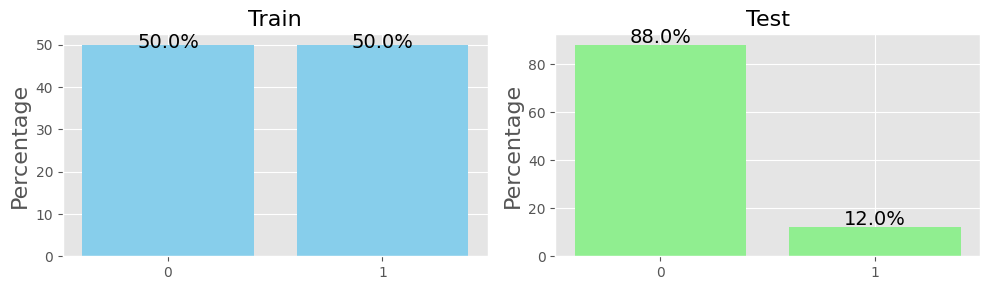

In [13]:
import matplotlib.pyplot as plt

train_counts = b_train.y_train.value_counts(normalize=True).round(2).sort_index()
test_counts = b_train.y_test.value_counts(normalize=True).round(2).sort_index()

fig = plt.figure(figsize=(10, 3))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# Bar plot for training set
ax1.bar(train_counts.index.astype(str), train_counts.values * 100, color='skyblue')
ax1.set_title("Train", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

for i, v in enumerate(train_counts.values * 100):
    ax1.text(i, v + 1, f"{v:.1f}%", ha='center', va='center_baseline', fontsize=14)

# Bar plot for test set
ax2.bar(test_counts.index.astype(str), test_counts.values * 100, color='lightgreen')
ax2.set_title("Test", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

for i, v in enumerate(test_counts.values * 100):
    ax2.text(i, v + 1, f"{v:.1f}%", ha='center', va='baseline', fontsize=14)

plt.tight_layout()

plt.show()

## Binary Classification

First, we do binary classification. Since the disease cases are small percentage of the overall observations, we used SMOTE to oversample the minority class.

We have already trained the models on the random half of the data stratified by the output.

The following plots demonstrate the performance comparisons.

In [3]:
b_eval = BinaryClassificationEvaluation(df)
b_eval.evaluate()
print(b_eval)

              svc    rf   xgb    nn    lr
sensitivity  0.61  0.74  0.82  0.82  0.84
specificity  0.98  0.99  0.97  0.99  0.96
f1_score     0.69  0.82  0.81  0.86  0.80
auc          0.93  0.97  0.96  0.96  0.96
mcc          0.66  0.81  0.78  0.84  0.77


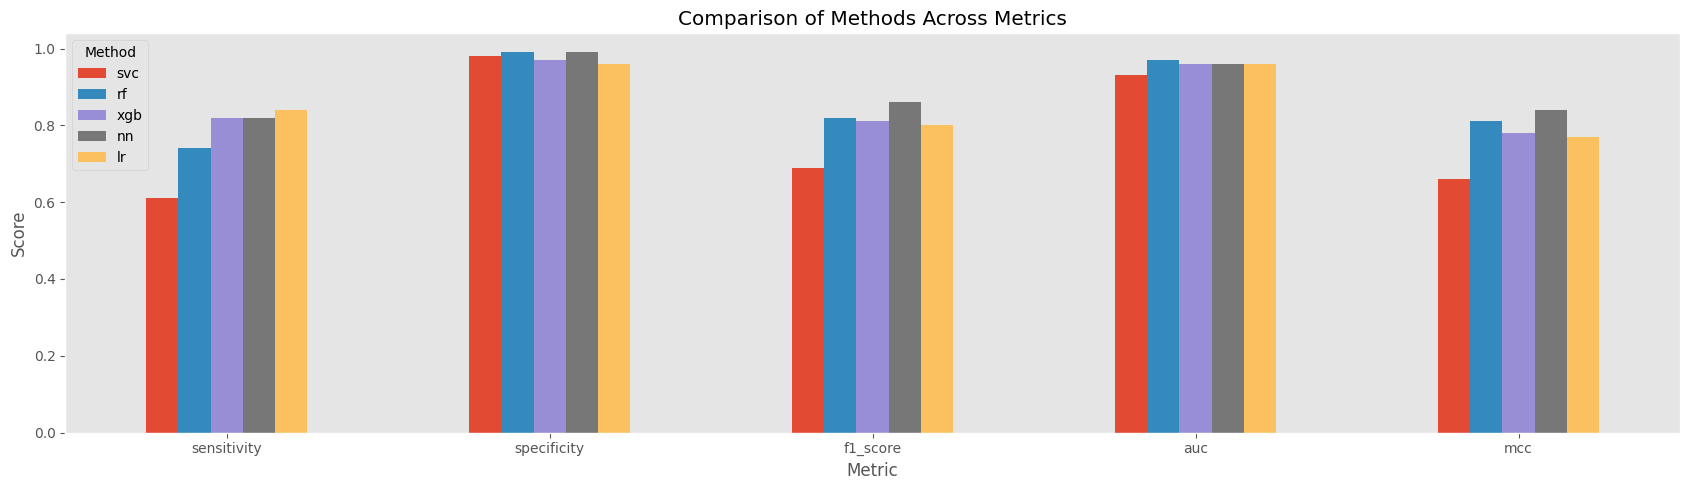

In [4]:
b_eval.ModelsPerformanceBarPlot()

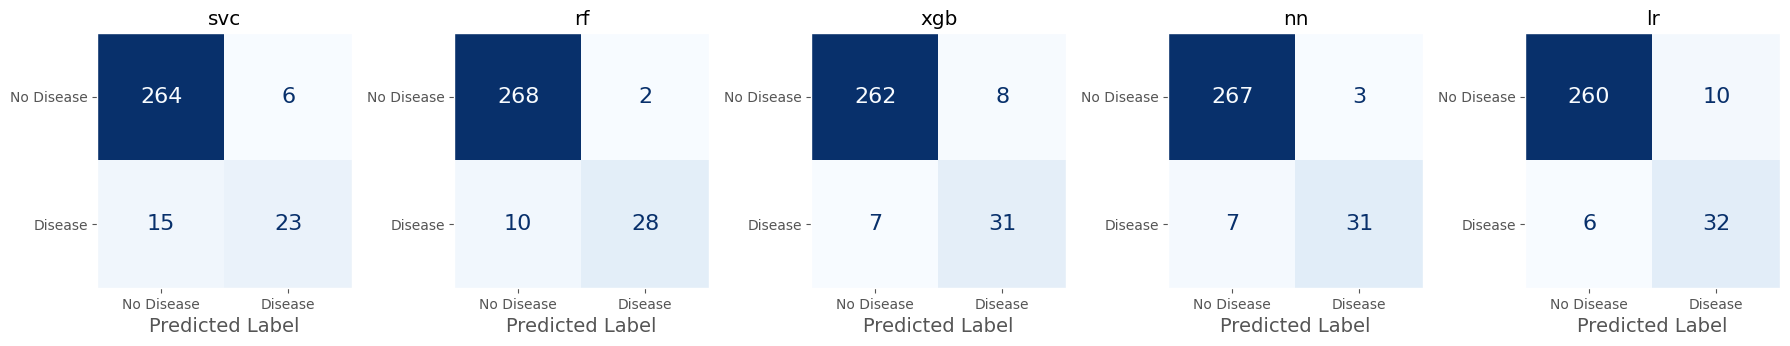

In [4]:
b_eval.ModelsConfusion()

## Multi-class Classification

Here, we do multi-class classification to discriminate not only healthy individuals from the disease ones, but also hepatitis C, fibrosis and cirrhosis cases from each other and from healthy individuals. Half of the data is used for training, where the disease cases are synthetically generated using SMOTE approach. The following plot shows that after this operation there are equal number of observations in each disease class.

We need to repeat the same feature transformation on the new X_train (since the split is now based on multi-categorical output variable, X_train is different from the one obtained based on the binary outcome.)A

In [3]:
m_train = MultiClassificationTraining(df)

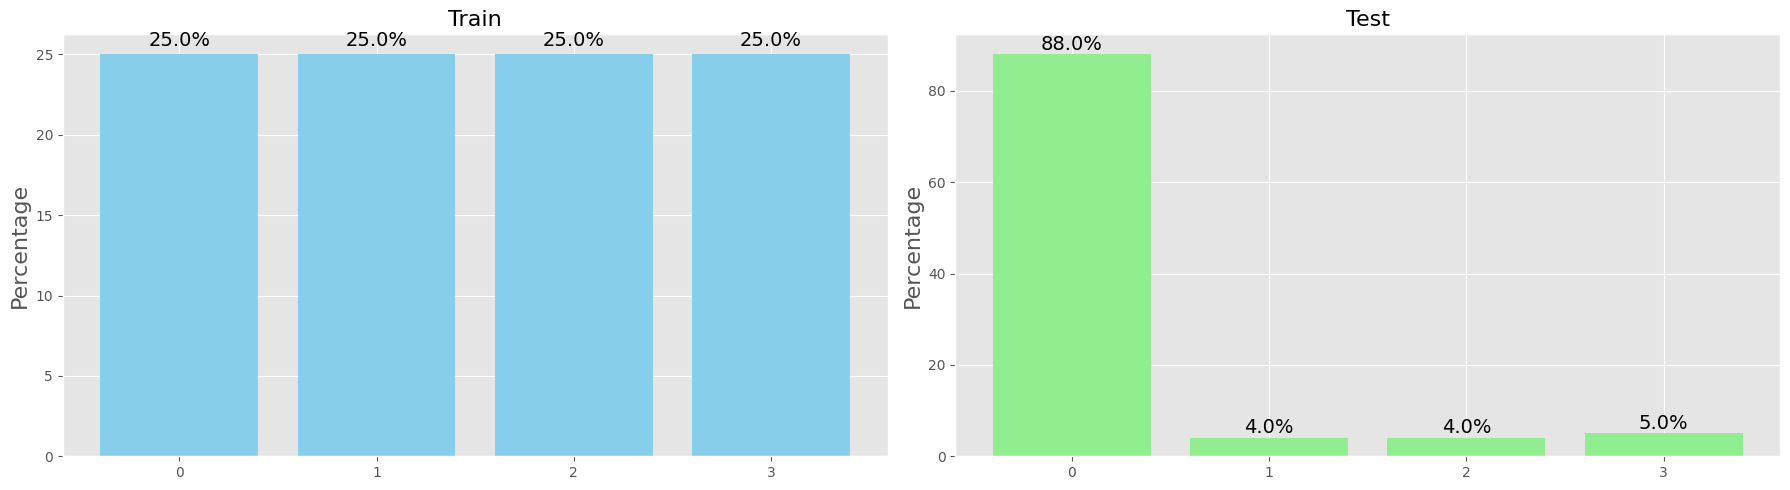

In [4]:
train_counts = m_train.y_train.value_counts(normalize=True).round(2).sort_index()
test_counts = m_train.y_test.value_counts(normalize=True).round(2).sort_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

#train
axes[0].bar(train_counts.index.astype(str), train_counts.values * 100, color='skyblue')
axes[0].set_title("Train", fontsize=16)
axes[0].set_ylabel("Percentage", fontsize=16)
for i, v in enumerate(train_counts.values * 100):
    axes[0].text(i, v + 1, f"{v:.1f}%", ha='center', va='center_baseline', fontsize=14)

#test
axes[1].bar(test_counts.index.astype(str), test_counts.values * 100, color='lightgreen')
axes[1].set_title("Test", fontsize=16)
axes[1].set_ylabel("Percentage", fontsize=16)
for i, v in enumerate(test_counts.values * 100):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center', va='baseline', fontsize=14)

plt.tight_layout()
plt.show()

Random Forest and Neural Network have similar performances and better than support vector classifier and logistic regression. Logistic regression performs poorly on the family of F1 measures and MCC score.

In [3]:
m_eval = MultiClassificationEvaluation(df)
m_eval.evaluate()

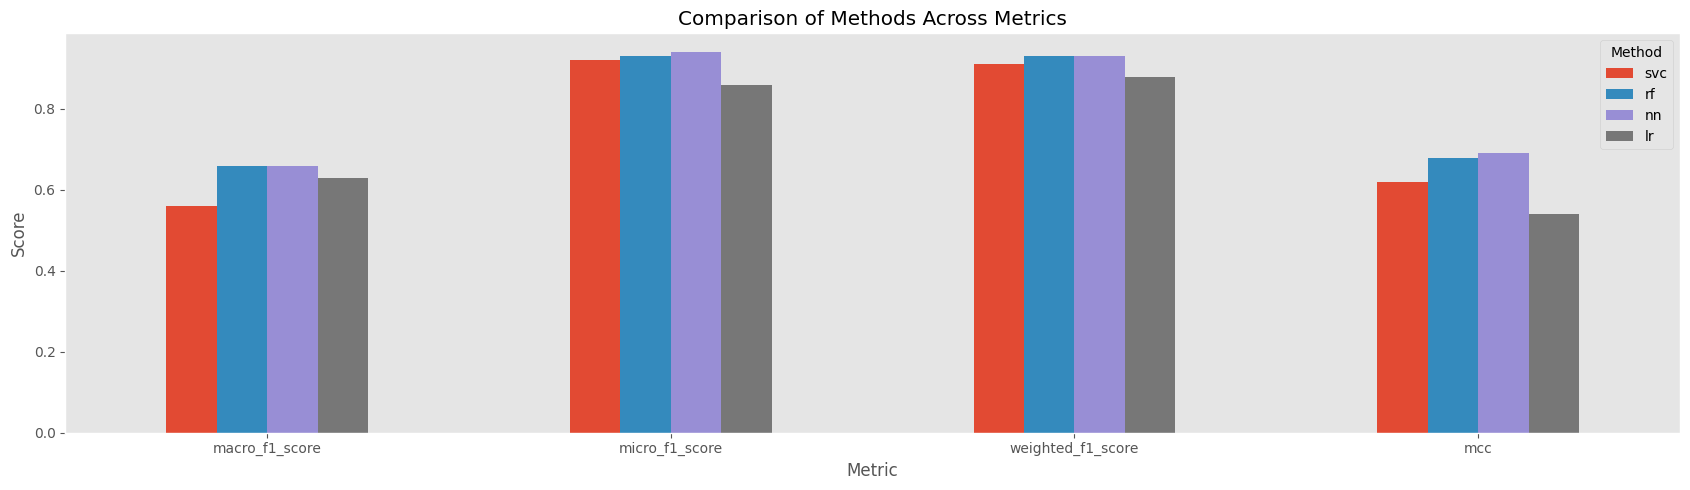

In [4]:
m_eval.ModelsPerformanceBarPlot()

Almost all methods have the same performance regarding the cirrhosis paitents: 13 cases are identified correctly and 1 individual is identified as healthy. Regarding hepatitis C and fibrosis cases, logistic regression classifies correctly the highest number of individuals, but it misclassifies many healthy patients as disease cases. Neural network makes the least amount of errors when classifying healthy individuals.

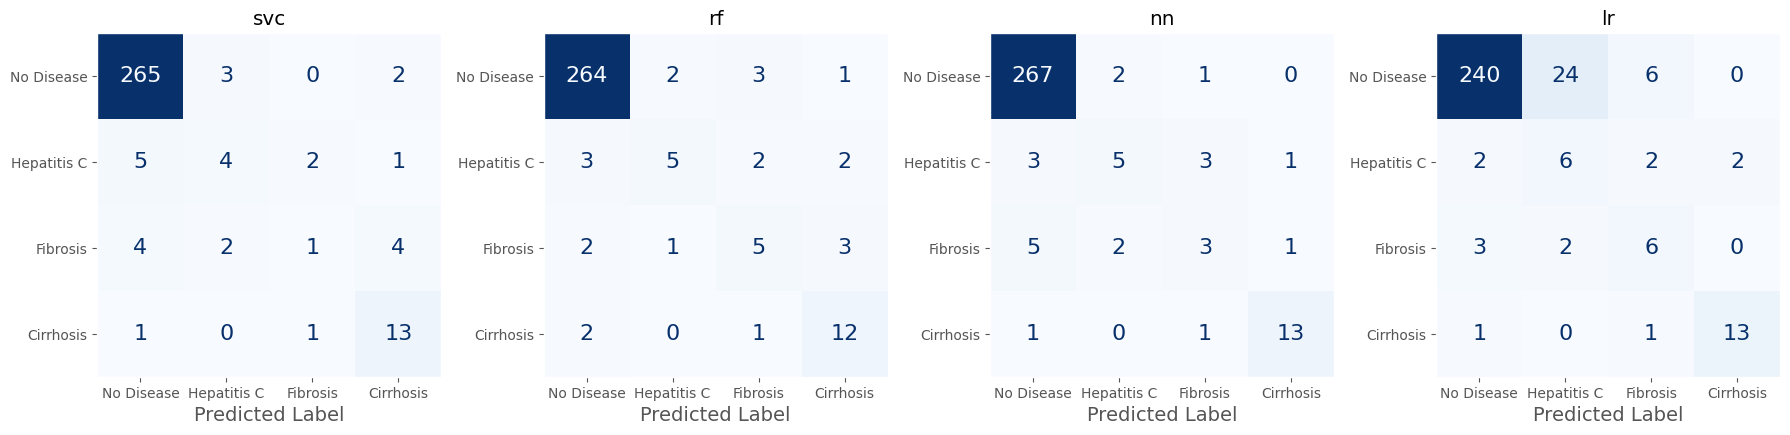

In [5]:
m_eval.ModelsConfusion()